In [1]:
import os

data_dir = '/home/james/Program/KerasLearning/data/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values= [float(x) for  x in line.split(',')[1:]]
    float_data[i, :] = values

In [4]:
from matplotlib import pyplot as plt

temp = float_data[:, 1] # temperature
plt.plot(range(len(temp)), temp)

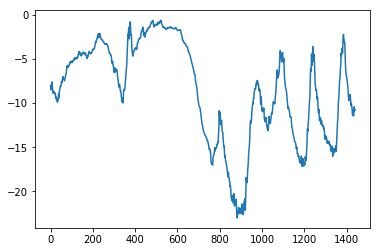

In [5]:
# Ten day`s plot
plt.plot(range(1440), temp[:1440])

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:20000].std(axis=0)
float_data /= std

In [7]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                    min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      step=step,
                      batch_size=batch_size)

test_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      step=step,
                      batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [9]:
from IPython.display import clear_output

In [10]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        clear_output(wait=True)
        print(step)
        samples, targets = next(val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [11]:
evaluate_naive_method()

768
0.335517562861696


In [12]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.2169252476686383

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 7s 14ms/step - loss: 1.6056 - val_loss: 0.5099
Epoch 2/20
500/500 [==============================] - 7s 13ms/step - loss: 0.4638 - val_loss: 0.4096
Epoch 3/20
500/500 [==============================] - 7s 13ms/step - loss: 0.3326 - val_loss: 0.3561
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3123 - val_loss: 0.3416
Epoch 5/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2983 - val_loss: 0.3778
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2911 - val_loss: 0.3475
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2836 - val_loss: 0.3585
Epoch 8/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2776 - val_loss: 0.3524
Epoch 9/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2703 - val_loss: 0.4015
Epoch 10/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2663 - val_lo

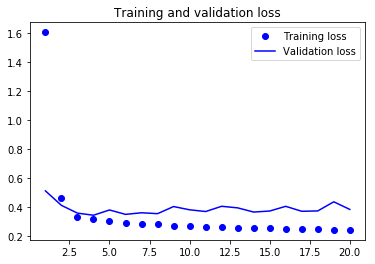

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data = val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 100s 201ms/step - loss: 0.3451 - val_loss: 0.3407
Epoch 2/20
500/500 [==============================] - 100s 200ms/step - loss: 0.3281 - val_loss: 0.3102
Epoch 3/20
500/500 [==============================] - 100s 200ms/step - loss: 0.3216 - val_loss: 0.3087
Epoch 4/20
500/500 [==============================] - 100s 200ms/step - loss: 0.3149 - val_loss: 0.3081
Epoch 5/20
500/500 [==============================] - 99s 198ms/step - loss: 0.3100 - val_loss: 0.3119
Epoch 6/20
500/500 [==============================] - 100s 200ms/step - loss: 0.3031 - val_loss: 0.3121
Epoch 7/20
500/500 [==============================] - 100s 199ms/step - loss: 0.2983 - val_loss: 0.3151
Epoch 8/20
500/500 [==============================] - 100s 200ms/step - loss: 0.2928 - val_loss: 0.3242
Epoch 9/20
500/500 [==============================] - 100s 199ms/step - loss: 0.2876 - val_loss: 0.3143
Epoch 10/20
500/500 [==============================] - 99s 199ms/

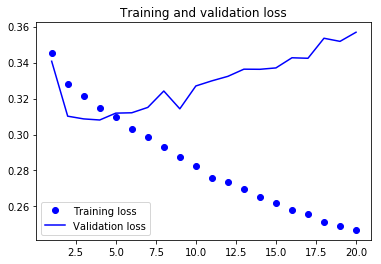

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 113s 226ms/step - loss: 0.3880 - val_loss: 0.3235
Epoch 2/40
500/500 [==============================] - 113s 225ms/step - loss: 0.3634 - val_loss: 0.3167
Epoch 3/40
500/500 [==============================] - 115s 229ms/step - loss: 0.3540 - val_loss: 0.3179
Epoch 4/40
500/500 [==============================] - 113s 226ms/step - loss: 0.3516 - val_loss: 0.3110
Epoch 5/40
500/500 [==============================] - 113s 227ms/step - loss: 0.3468 - val_loss: 0.3084
Epoch 6/40
500/500 [==============================] - 114s 228ms/step - loss: 0.3456 - val_loss: 0.3095
Epoch 7/40
500/500 [==============================] - 114s 228ms/step - loss: 0.3417 - val_loss: 0.3131
Epoch 8/40
500/500 [==============================] - 115s 230ms/step - loss: 0.3396 - val_loss: 0.3101
Epoch 9/40
500/500 [==============================] - 113s 227ms/step - loss: 0.3361 - val_loss: 0.3113
Epoch 10/40
500/500 [==============================] - 113s 227m

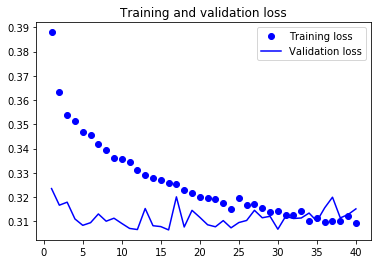

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64,
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 234s 468ms/step - loss: 0.3923 - val_loss: 0.3210
Epoch 2/40
500/500 [==============================] - 230s 460ms/step - loss: 0.3688 - val_loss: 0.3257
Epoch 3/40
500/500 [==============================] - 229s 459ms/step - loss: 0.3588 - val_loss: 0.3345
Epoch 4/40
500/500 [==============================] - 231s 461ms/step - loss: 0.3542 - val_loss: 0.3134
Epoch 5/40
500/500 [==============================] - 230s 459ms/step - loss: 0.3476 - val_loss: 0.3139
Epoch 6/40
500/500 [==============================] - 230s 460ms/step - loss: 0.3436 - val_loss: 0.3140
Epoch 7/40
500/500 [==============================] - 233s 466ms/step - loss: 0.3413 - val_loss: 0.3227
Epoch 8/40
500/500 [==============================] - 229s 459ms/step - loss: 0.3378 - val_loss: 0.3111
Epoch 9/40
500/500 [==============================] - 228s 457ms/step - loss: 0.3334 - val_loss: 0.3067
Epoch 10/40
500/500 [==============================] - 228s 456m

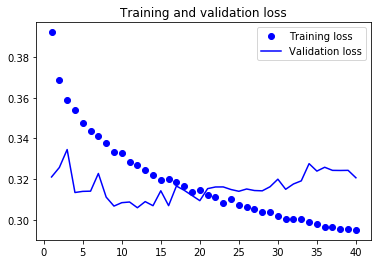

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
# we found out the computation cost is pretty high but the loss didn`t improve much

In [25]:
# Bidirectional RNN 
# It`s performance is better than RNN
# Usually good at the natural language
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                    min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets

In [26]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      step=step,
                      batch_size=batch_size)

test_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      step=step,
                      batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [27]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64,
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 230s 460ms/step - loss: 0.5794 - val_loss: 0.5565
Epoch 2/40
500/500 [==============================] - 229s 458ms/step - loss: 0.5546 - val_loss: 0.5358
Epoch 3/40
500/500 [==============================] - 229s 457ms/step - loss: 0.4905 - val_loss: 0.4267
Epoch 4/40
500/500 [==============================] - 229s 458ms/step - loss: 0.3841 - val_loss: 0.3364
Epoch 5/40
500/500 [==============================] - 229s 458ms/step - loss: 0.3493 - val_loss: 0.3311
Epoch 6/40
500/500 [==============================] - 229s 457ms/step - loss: 0.3408 - val_loss: 0.3446
Epoch 7/40
500/500 [==============================] - 229s 457ms/step - loss: 0.3358 - val_loss: 0.3272
Epoch 8/40
500/500 [==============================] - 229s 458ms/step - loss: 0.3300 - val_loss: 0.3257
Epoch 9/40
500/500 [==============================] - 229s 458ms/step - loss: 0.3269 - val_loss: 0.3323
Epoch 10/40
500/500 [==============================] - 229s 457m

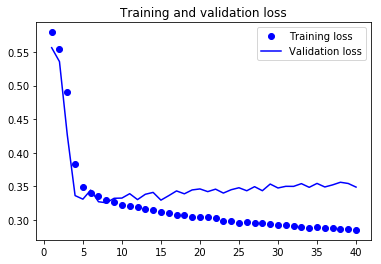

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
# we found out the backwards GRU`s effect is worser than the basic method

In [31]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 69s 3ms/step - loss: 0.4990 - acc: 0.7638 - val_loss: 0.3460 - val_acc: 0.8692
Epoch 2/10
20000/20000 [==============================] - 68s 3ms/step - loss: 0.3277 - acc: 0.8751 - val_loss: 0.3629 - val_acc: 0.8466
Epoch 3/10
20000/20000 [==============================] - 68s 3ms/step - loss: 0.2616 - acc: 0.9007 - val_loss: 0.3151 - val_acc: 0.8660
Epoch 4/10
20000/20000 [==============================] - 68s 3ms/step - loss: 0.2182 - acc: 0.9198 - val_loss: 0.3900 - val_acc: 0.8698
Epoch 5/10
20000/20000 [==============================] - 68s 3ms/step - loss: 0.1985 - acc: 0.9323 - val_loss: 0.4886 - val_acc: 0.8382
Epoch 6/10
20000/20000 [==============================] - 68s 3ms/step - loss: 0.1792 - acc: 0.9378 - val_loss: 0.4071 - val_acc: 0.8540
Epoch 7/10
20000/20000 [==============================] - 68s 3ms/step - loss: 0.1572 - acc: 0.9453 - val_loss: 0.3601 - val_acc:

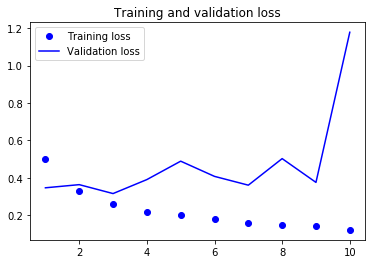

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
# It is as same the positive sequence

In [33]:
# So we combine positive sequence and the negative sequence than we have a double size 
# training
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 131s 7ms/step - loss: 0.5586 - acc: 0.7169 - val_loss: 0.4294 - val_acc: 0.8168
Epoch 2/10
20000/20000 [==============================] - 129s 6ms/step - loss: 0.3273 - acc: 0.8747 - val_loss: 0.4143 - val_acc: 0.8424
Epoch 3/10
20000/20000 [==============================] - 129s 6ms/step - loss: 0.2709 - acc: 0.8977 - val_loss: 0.3804 - val_acc: 0.8764
Epoch 4/10
20000/20000 [==============================] - 129s 6ms/step - loss: 0.2260 - acc: 0.9164 - val_loss: 0.3110 - val_acc: 0.8816
Epoch 5/10
20000/20000 [==============================] - 129s 6ms/step - loss: 0.2035 - acc: 0.9276 - val_loss: 0.3403 - val_acc: 0.8842
Epoch 6/10
20000/20000 [==============================] - 129s 6ms/step - loss: 0.1837 - acc: 0.9365 - val_loss: 0.4946 - val_acc: 0.8124
Epoch 7/10
20000/20000 [==============================] - 129s 6ms/step - loss: 0.1685 - acc: 0.9420 - val_loss: 0.3834 - v

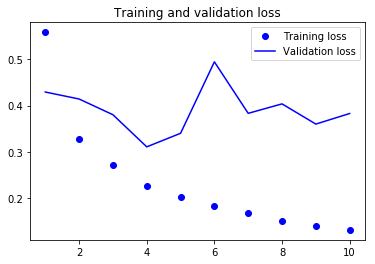

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
# We may find out the model overfitting quite quickly ==> having double parameters

In [35]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                    min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [36]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      step=step,
                      batch_size=batch_size)

test_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      step=step,
                      batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [37]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 193s 386ms/step - loss: 0.3389 - val_loss: 0.3194
Epoch 2/40
500/500 [==============================] - 192s 384ms/step - loss: 0.3173 - val_loss: 0.3171
Epoch 3/40
500/500 [==============================] - 192s 384ms/step - loss: 0.3094 - val_loss: 0.3137
Epoch 4/40
500/500 [==============================] - 192s 384ms/step - loss: 0.3053 - val_loss: 0.3159
Epoch 5/40
500/500 [==============================] - 192s 384ms/step - loss: 0.2956 - val_loss: 0.3126
Epoch 6/40
500/500 [==============================] - 192s 384ms/step - loss: 0.2861 - val_loss: 0.3179
Epoch 7/40
500/500 [==============================] - 192s 384ms/step - loss: 0.2816 - val_loss: 0.3225
Epoch 8/40
500/500 [==============================] - 192s 384ms/step - loss: 0.2745 - val_loss: 0.3343
Epoch 9/40
500/500 [==============================] - 192s 384ms/step - loss: 0.2674 - val_loss: 0.3299
Epoch 10/40
500/500 [==============================] - 192s 384m

In [38]:
# convnet for sequence data
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('Loading data')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (smaples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data
25000 train sequences
25000 test sequences
Pad sequences (smaples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [42]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


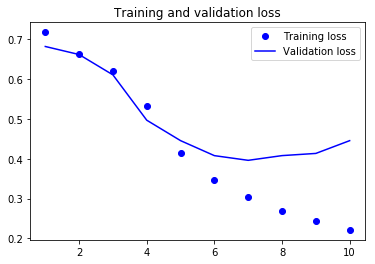

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [46]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 8s 16ms/step - loss: 0.4857 - val_loss: 0.5049
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.4181 - val_loss: 0.5196
Epoch 3/20
500/500 [==============================] - 7s 13ms/step - loss: 0.3882 - val_loss: 0.5091
Epoch 4/20
500/500 [==============================] - 7s 13ms/step - loss: 0.3716 - val_loss: 0.5311
Epoch 5/20
500/500 [==============================] - 7s 13ms/step - loss: 0.3561 - val_loss: 0.5138
Epoch 6/20
500/500 [==============================] - 7s 13ms/step - loss: 0.3468 - val_loss: 0.5376
Epoch 7/20
500/500 [==============================] - 7s 13ms/step - loss: 0.3350 - val_loss: 0.5345
Epoch 8/20
500/500 [==============================] - 7s 13ms/step - loss: 0.3291 - val_loss: 0.5509
Epoch 9/20
500/500 [==============================] - 7s 13ms/step - loss: 0.3205 - val_loss: 0.5332
Epoch 10/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3144 - val_lo

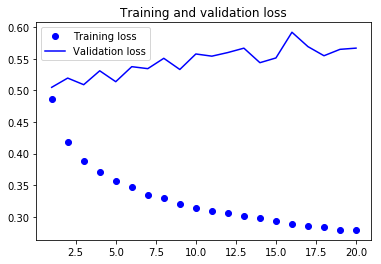

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [49]:
step = 3
lookback = 720
delay = 144

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001- lookback) // 128

In [51]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_10 (GRU)                 (None, 32)                6240      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 43s 86ms/step - loss: 0.3878 - val_loss: 0.3244
Epoch 2/20
500/500 [================

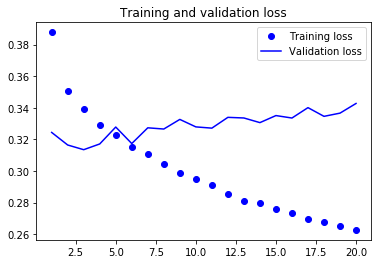

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
